# Exemples simples d'utilisation de Dask

Ce notebook montre plusieurs choses :
* Comment démarrer un cluster Dask depuis un notebook sur HAL, et le rendre adaptatif
* Comment manipuler des séries temporelles avec le module dask.dataframe
* Comment utiliser les dataframes et l'API Client pour soumettre une séries de simulation ou de calculs assez long (> 100 ms)

## Démarrage et configuration du cluster

Grâce au module dask_jobqueue, il est possible de démarrer un sous-cluster Dask sur le cluster HAL, avec quelques lignes depuis un notebook.

### Imports initiaux et création du cluster

Ici on importe les classes principalement utilisées, puis on va créer un cluster sur PBS.
Ce cluster sera composé de worker Dask, lancés via des jobs PBS. Chaque job PBS utilisera 4 ncpus et 20 GB de mémoire dans PBS, et sera composé de 2 workers. C'est ce qui est définit dans le constructeur ci-dessous.
Ensuite, chaque job sera lancé indépendamment sur demande de notre part ou automatiquement si on l'a indiqué.

In [1]:
from dask_jobqueue import PBSCluster

cluster = PBSCluster(processes=1, cores=4, memory="20GB", local_directory='$TMPDIR',
                     project='DaskTest', walltime='01:00:00', interface='ib0')

En affichant le cluster dans le notebook, on doit voir un widget qui nous permet de faire varier la taille de notre cluster manuellement, ou de manière automatique (Adaptive cluster). On peut aussi configurer ça via des lignes des codes comme montré ci-dessous.

In [2]:
cluster

Spécification manuelle de la taille du cluster. Le paramètre donné est le nombre de workers Dask.

In [2]:
cluster.scale(8)

Indiquer qu'on veut un cluster adaptatif (dont la taille variera en fonction de la charge).

Lancer la cellule suivante (ou précédente) doit modifier les informations affichées dans le widget.

In [3]:
cluster.adapt(minimum=4, maximum=60)

### Déclaration du client

Afin que toutes les API de dask (dataframe, delayed, bag ...) utilisent le cluster Dask qu'on a démarré, il est indispensable d'initialiser un client.

On pourra de plus utiliser ce client pour soumettre des tâches dans la suite de cet exemple.

Afficher le client devrait indiquer la taille actuelle du cluster et donner un lien vers le Dashboard Dask. Ce lien ne fonctionne pas forcément depuis votre navigateur. Néanmoins, une technologie de proxy a été déployée, vous devriez donc pouvoir accéder au dashboard Dask à travers l'URL suivante :

https://jupyterhub.sis.cnes.fr/user/username/proxy/8787/status

Le port peut être différent du port par défaut qui est 8787.

In [5]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.120.43.90:58199 Dashboard: ../proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 40.00 GB


## Utilisation de l'API Client pour soumettre des simulations

Un cas typique d'utilisation du cluster : la soumission d'un calcul complexe (de quelques secondes à plusieurs minutes) sur un ensemble de paramètres d'entrée différent. Ce qu'on peut voir en faisant du Monte Carlo par exemple, mais dans d'autres cas aussi.

Le principe est donc de générer ou lire l'ensemble des paramètres à utiliser pour le calcul, puis de lancer ce calcul pour chaque jeu de paramètres. Cette démo est bien sur simplifiées, la fonction de calcul est une pure fonction python.

### Génération/lecture des données d'entrées

On considère ici que les paramètres d'entrées sont lu dans une dataframe pandas, qui est capable de lire des fichiers CSV, mais il est aussi possible d'en générer une nous même comme ci-dessous (mais avec des données plus intéressantes ...).
On part sur 1000 simulations ici, libre à vous de modifier ça !

In [6]:
#Generates parameters 
import pandas as pd
import numpy as np
#We generate random params, but could do this with some intelligence, or read it from a csv file
input_params = pd.DataFrame(np.random.randint(low=0, high=1000, size=(1000, 4)),
               columns=['a', 'b', 'c', 'd'])
input_params.head()

,a,b,c,d
0,206,368,939,341
1,830,53,810,538
2,58,736,598,713
3,26,9,173,220
4,466,306,640,73


### Définition de la méthode de calcul

La méthode ci-dessous se contente de simuler un calcul durant entre 0 et 2 secondes. On peut bien sur l'adapter, et eventuellement appeler un processus externe beaucoup plus long. A noter qu'il est important de retourner le résultat via python, et non dans un fichier !

In [7]:
# Launch a task on all of this params, dont wait for result
def my_costly_simulation(line):
    #print(line)
    import time
    import random
    time.sleep(random.random() * 2)
    return sum(line)

### Soumission du calcul

Il ne reste plus qu'à soumettre et éventuellement attendre la fin du calcul. 
La soumission n'est pas bloquante, le calcul s'effectuera en tache de fond sur le cluster Dask, n'hésitez pas à ouvrir l'application Dashboard de Dask pour voir l'avancement, et éventuellement l'elasticité du cluster si vous êtes en mode adaptatif.

In [8]:
futures = client.map(my_costly_simulation, input_params.values)

On peut aussi regarder les jobs en cours sur le cluster, et voir leur variation en exécutant plusieurs fois la cellule suivante.
N'hésitez pas à lancer plusieurs fois la simulation ci-dessus pour expérimenter. Il peut être nécessaire de réexécuter la cellule de la fonction de simulation, sinon Dask peut estimer que le même calcul lui est demandé, et ne rien faire.

In [9]:
!qstat -u $USER


admin01: 
                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
6535422.admin01 eynardbg qdev     jupyterhub  37436   1   1 5000mb 08:00 R 00:49
6536733.admin01 eynardbg qt1h     dask-worke   8878   1   4   19gb 01:00 R 00:00
6536734.admin01 eynardbg qt1h     dask-worke  32510   1   4   19gb 01:00 R 00:00
6536768.admin01 eynardbg qt1h     dask-worke    --    1   4   19gb 01:00 Q   -- 
6536769.admin01 eynardbg qt1h     dask-worke    --    1   4   19gb 01:00 Q   -- 
6536770.admin01 eynardbg qt1h     dask-worke    --    1   4   19gb 01:00 Q   -- 
6536771.admin01 eynardbg qt1h     dask-worke    --    1   4   19gb 01:00 Q   -- 
6536772.admin01 eynardbg qt1h     dask-worke    --    1   4   19gb 01:00 Q   -- 
6536773.admin01 eynardbg qt1h     dask-worke    --    1   4   19gb 01:00 Q   -- 
6536774.admin01 eyn

### Récupération des résultats

Pour l'instant, les résultats sont stockés sur les workers Dask, on peut récupérer ceux-ci à l'aide la la méthode gather.
Ici, on fait aussi en sorte de fusionner paramètres d'entrée et résultats dans une jolie table, qu'on pourra sauvegarder sous format tabulaire : CSV, HDF5...

In [10]:
# Block until result, and add the column to initial input tables
results = client.gather(futures)
output = input_params.copy()
output['result'] = pd.Series(results, index=output.index)
output.sample(5)

,a,b,c,d,result
713,171,618,257,407,1453
880,394,162,860,397,1813
291,496,120,893,920,2429
635,745,640,233,194,1812
927,664,195,64,851,1774


## Utilisation des dataframe pour faire des traitements time series

Cette exemple est récupéré du projet dask-example, vous pouvez consulter l'exemple complet sur le github associé : https://github.com/dask/dask-examples/blob/master/dataframe.ipynb.

On génère juste des timeseries assez volumineuses, et on fait quelques calculs dessus, mais aussi des affichages. Là aussi, n'hésitez pas à regarder ce qui se passe sur le dashboard Dask !

In [11]:
import dask.dataframe as dd
df = dd.demo.make_timeseries('2000-01-01', '2020-12-31', freq='1s', partition_freq='1M',
                             dtypes={'name': str, 'id': int, 'x': float, 'y': float})

On redécoupe les données, puis calcule une moyenne par semaine des paramètres x et y.
Comme on affiche que la head, on ne va pas calculer sur tout le dataset.

In [12]:
df[['x', 'y']].resample('1w').mean().head()

,x,y
2000-02-06,0.000400,-0.000164
2000-02-13,0.000293,0.000465
2000-02-20,0.000364,0.000392
2000-02-27,-0.000031,-0.001355


Ici on va afficher la moyenne en fonction du temps, il faut donc calculer sur tout le dataset, ça va être plus long.

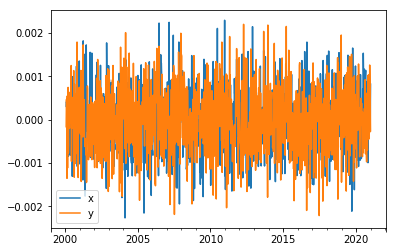

In [13]:
%matplotlib inline
df[['x', 'y']].resample('1w').mean().compute().plot()